# IBM Attrition Study

(à améliorer) Le but de cette étude est de prédire le taux d'attrition des employées d'IBM en fonction de plusieurs variables, qui concernent à la fois des données personnelles sur l'individu (son âge, son niveau d'étude, etc), des données professionelles (comme le département dans lequel l'individu travaille, son salaire, etc) et l'appréciation de l'individu sur son travail (qualité de ses relations avec ses collègues, work-life balance etc).

# Importation de la base de donnée et description de nos données

Téléchargement des données : Connectez vous sur une autre page de votre navigateur à votre compte Kaggle. 
Si vous n'avez pas de compte Kaggle, nous vous avons fourni en pièce jointe du mail la base de donnée

In [1]:
import urllib.request as ur
ur.urlretrieve ("https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv"
                , "WA_Fn-UseC_-HR-Employee-Attrition.zip")

('WA_Fn-UseC_-HR-Employee-Attrition.zip',
 <http.client.HTTPMessage at 0x24b89ab3160>)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFpr 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC

C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline 
#pour que nos graphes soient inclus dans notre notebook, en dessous de notre code 

In [4]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")

#Première analyse de notre data set
print('Notre indexation:', df.index)
print('Notre base de donnée est constituée de', df.shape[1], 'variables et de', df.shape[0], 'observations. \n')

Notre indexation: RangeIndex(start=0, stop=1470, step=1)
Notre base de donnée est constituée de 35 variables et de 1470 observations. 



In [5]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
print('Voyons nos variables ainsi que leur nombre de données manquantes:\n',df.isnull().sum()) # pas de Missing Values
print ("Il n'y a aucune données manquantes.")

Voyons nos variables ainsi que leur nombre de données manquantes:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
Yea

## Quelques explications sur certaines variables de notre base de données:

- EmployeeCount renvoie toujours le nombre '1', nous allons donc supprimer cette colonne
- EmployeeNumber correspond à un numéro unique associé à un employé
- JobRole correspond au titre d'une personne
- Percent salary hike: pourcentage d'augmentation de salaire entre 2015 et 2016. 
- Les variables Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction et StockOptionLevel  sont des variables qualitatives notées de 1 à 4 (ou à 5), 1 étant la pire note et 4 (ou 5)la meilleure. 
    - Pour Education: Education 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'
    - Environment satisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobInvolvement: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobSatisfaction :  1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - PerformanceRating : 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'
    - RelationshipSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - WorkLifeBalance 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

Nous n'avons pas trouvé d'explication pour HourlyRate, DailyRate et MonthlyRate, nous allons essayer de trouver une explication. 



In [7]:
print('Intéressons nous maintenant au type de chaque variable: \n', df.dtypes)

Intéressons nous maintenant au type de chaque variable: 
 Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int

Nous allons changer le type de certaines variables afin les transformer dans un format approprié et d'augmenter ainsi notre vitesse de calcul. Pour ce faire, nous avons considéré la valeur maximale de chaque variable et associé le format approprié. 

In [8]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")
print(sys.getsizeof(df))
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",", dtype={
    'Age': np.int8, 
    'Attrition': str, 
    'BusinessTravel': str, 
    'DailyRate': np.int16, 
    'Department': str, 
    'DistanceFromHome': np.int8, 
    'Education': np.int8, 
    'EducationField': str, 
    'EmployeeCount': np.int8, 
    'EmployeeNumber': np.int16, 
    'EnvironmentSatisfaction':np.int8, 
    'Gender': str,
    'JobRole': str, 
    'MaritalStatus': str,
    'Over18': str, 
    'OverTime': str, 
    'HourlyRate' :np.int8,
    'JobInvolvement': np.int8,
    'JobLevel': np.int8,
    'JobSatisfaction': np.int8, 
    'MonthlyIncome': np.int16, 
    'MonthlyRate': np.int16,
    'NumCompaniesWorked': np.int8, 
    'PercentSalaryHike': np.int8,
    'PerformanceRating': np.int8,
    'RelationshipSatisfaction': np.int8,
    'StandardHours': np.int8,
    'StockOptionLevel': np.int8,
    'TotalWorkingYears': np.int8,
    'TrainingTimesLastYear': np.int8,
    'WorkLifeBalance': np.int8,
    'YearsAtCompany': np.int8,
    'YearsInCurrentRole': np.int8,
    'YearsSinceLastPromotion': np.int8,
    'YearsWithCurrManager': np.int8})
print(sys.getsizeof(df))

1177193
915533


# Preprocessing -Tentatives d'explications de certaines variables :

Essayons de trouver une explication à HourlyRate, DailyRate et MonthlyRate. 

### HourlyRate, DailyRate, MonthlyRate

In [9]:
print(df["HourlyRate"].describe())
print(df['DailyRate'].describe())
print(df['MonthlyRate'].describe())

# HourlyRate en %
# Hypothèse la plus plausible : HourlyRate est un taux de performance par heure (ou efficacité)

count    1470.000000
mean       65.891156
std        20.329428
min        30.000000
25%        48.000000
50%        66.000000
75%        83.750000
max       100.000000
Name: HourlyRate, dtype: float64
count    1470.000000
mean      802.485714
std       403.509100
min       102.000000
25%       465.000000
50%       802.000000
75%      1157.000000
max      1499.000000
Name: DailyRate, dtype: float64
count     1470.000000
mean     14313.103401
std       7117.786044
min       2094.000000
25%       8047.000000
50%      14235.500000
75%      20461.500000
max      26999.000000
Name: MonthlyRate, dtype: float64


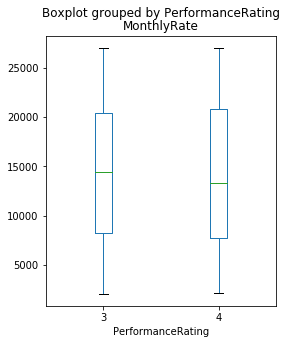

In [10]:
df.boxplot('MonthlyRate', by = 'PerformanceRating', grid = False, figsize = (4,5))

In [11]:
df['EducationField'].unique()

array(['Life Sciences', 'Other', 'Medical', 'Marketing',
       'Technical Degree', 'Human Resources'], dtype=object)

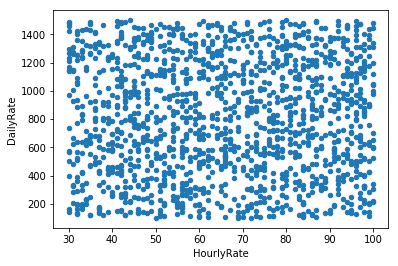

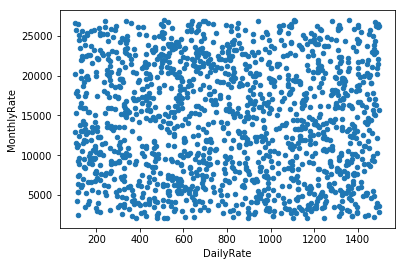

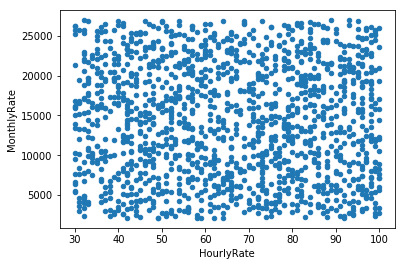

In [12]:
#Lien entre DailyRate, HourlyRate et MonthlyRate

df.plot(x = 'HourlyRate', y = 'DailyRate', kind = 'scatter')
df.plot(x = 'DailyRate', y = 'MonthlyRate', kind = 'scatter')
df.plot(x = 'HourlyRate', y = 'MonthlyRate', kind = 'scatter')

# Pas de relation linéaire entre les 3 variables 

In [13]:
# Unité de mesure de DailyRate?

# Hypothese 1: 802 = 8:02 ? en moyenne, fait sens
#mais min et max impossibles (1h/jour vs 14h/jour ?)

# Regardons s'il y a bien une corrélation avec OverTime
print(df["OverTime"].head())
print(df[df['OverTime']=='Yes']['DailyRate'].describe())

# Certaines personnes en Overtime travaillent toujours 1h/ jour : Hypothèse 1 rejetée

0    Yes
1     No
2    Yes
3    Yes
4     No
Name: OverTime, dtype: object
count     416.000000
mean      808.350962
std       407.262601
min       103.000000
25%       463.250000
50%       799.000000
75%      1171.750000
max      1498.000000
Name: DailyRate, dtype: float64


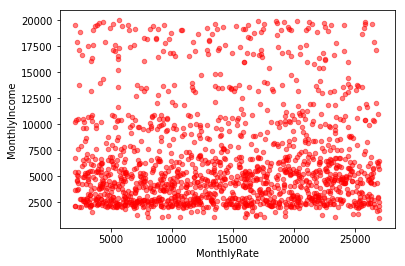

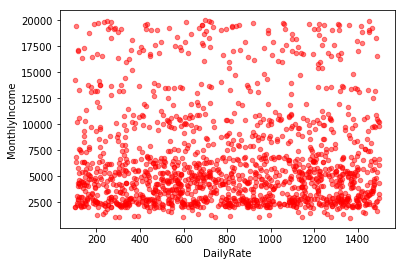

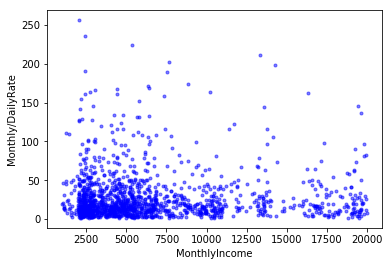

In [14]:
# Hypothèse 2: MonthlyRate et DailyRate sont liés au revenu par jour/par mois

df.plot(x = 'MonthlyRate', y = 'MonthlyIncome', kind = 'scatter', alpha = 0.5, color = 'red') # alpha = transparence
df.plot(x = 'DailyRate', y = 'MonthlyIncome', kind = 'scatter', alpha = 0.5, color = 'red') 

# pas de relation linéaire ici encore entre MonthlyIncome en fonction de MonthlyRate et MonthlyIncome en fonction de DailyRate
# Hypothèse 2 rejetée

#MonthlyRate et DailyRate ont le même comportement en fonction de MonthlyIncome
fig, ax = plt.subplots(1,1)
ax.plot(df['MonthlyIncome'], df['MonthlyRate']/df['DailyRate'], '.', alpha = 0.5, color = 'blue')
ax.set_xlabel("MonthlyIncome")
ax.set_ylabel('Monthly/DailyRate')
plt.show()

#Toujours pas de relation linéaire mais relation similaire à 1/x.... SIGNIFICATION ??

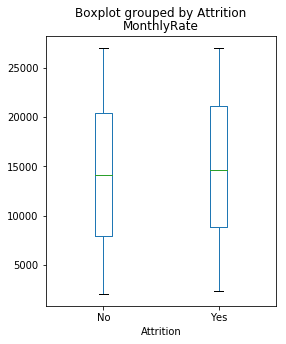

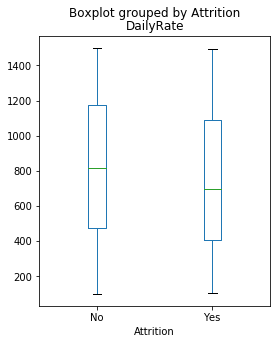

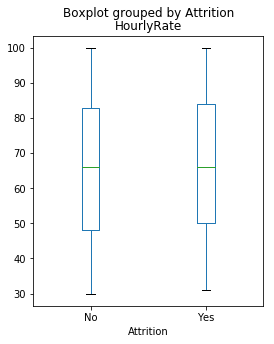

In [15]:
df.boxplot('MonthlyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('DailyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('HourlyRate', by = 'Attrition', grid = False, figsize = (4,5))

# MonthlyRate n'est pas significatif pour expliquer l'attrition, HourlyRate non plus, DailyRate un peu plus
# CONCLUSION: On va considérer que DailyRate est un indice de performance d'unité inconnue, et MonthlyRate NS - à éliminer


### EmployeeCount, EmployeeNumber, StandardHours & Over18

In [16]:
print(df['EmployeeCount'].unique()) # A supprimer : 1 partout
print(df['StandardHours'].unique()) # A supprimer : 80 pour tout le monde
print(df['EmployeeNumber'].describe()) # A supprimer : matricule de l'employé

print(df[df['Over18']== 'Y'].shape[0])
print(df[df['Over18']=='N'].shape[0]) # A supprimer : Yes pour tout le monde

[1]
[80]
count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: EmployeeNumber, dtype: float64
1470
0


# Preprocessing - Etude de la population

Le but est ici de voir quel type de population, notamment pour les variables qualitatives

In [76]:
# Changement de certains noms de valeurs dans la base

df['Department'].replace(to_replace ='Research & Development', value = 'R&D', inplace = True)
df['Department'].replace(to_replace ='Human Resources', value = 'HR', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Rarely', value = 'Rarely', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Frequently', value = 'Frequently', inplace = True)

['Female' 'Male']


array(['Rarely', 'Frequently', 'Non-Travel'], dtype=object)

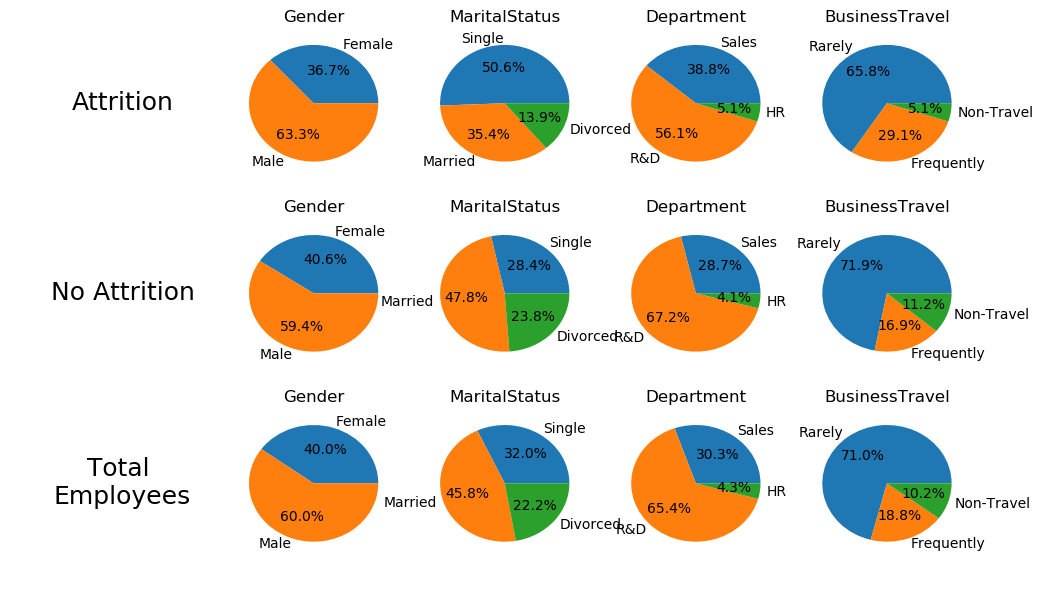

In [77]:
def titre(tlist,n):
    j = 0
    for i in n:
        plt.subplot(grid[i,0])
        plt.axis('off')
        plt.text(0.5,0.5, tlist[j] , ha='center', va='center', size = 18)
        j +=1
        
fig = plt.figure(figsize=(10,6), dpi=100)
grid = gridspec.GridSpec(3,5)
        
df0 = df[df['Attrition']=='Yes']
df1 = df[df['Attrition']=='No']
dA = [df0, df1, df]

titre(['Attrition', 'No Attrition', 'Total \nEmployees'],range(3))
var = ['Gender','MaritalStatus','Department','BusinessTravel']

j = 0
for d in dA:
    lab = list()
    k = 1
    for v in var:
        lab = df[v].unique()
        frac = list()
        for l in range(len(lab)):
            frac.append(d[d[v] == lab[l]].shape[0])
        plt.subplot(grid[j,k])
        plt.pie(frac, labels=lab, autopct='%1.1f%%')
        plt.title(v)
        k +=1
    j +=1

plt.tight_layout()
plt.show()  
    
# Le plus flagrant : les personnes célibataires sont plus susceptibles de partir que les personnes mariées
# les hommes ont un peu plus tendance à partir que les femmes
# le département le plus concerné par les départs est le département des Sales, ensuite les RH
# les personnes partant fréquemment en voyages d'affaire sont plus susceptibles de partir

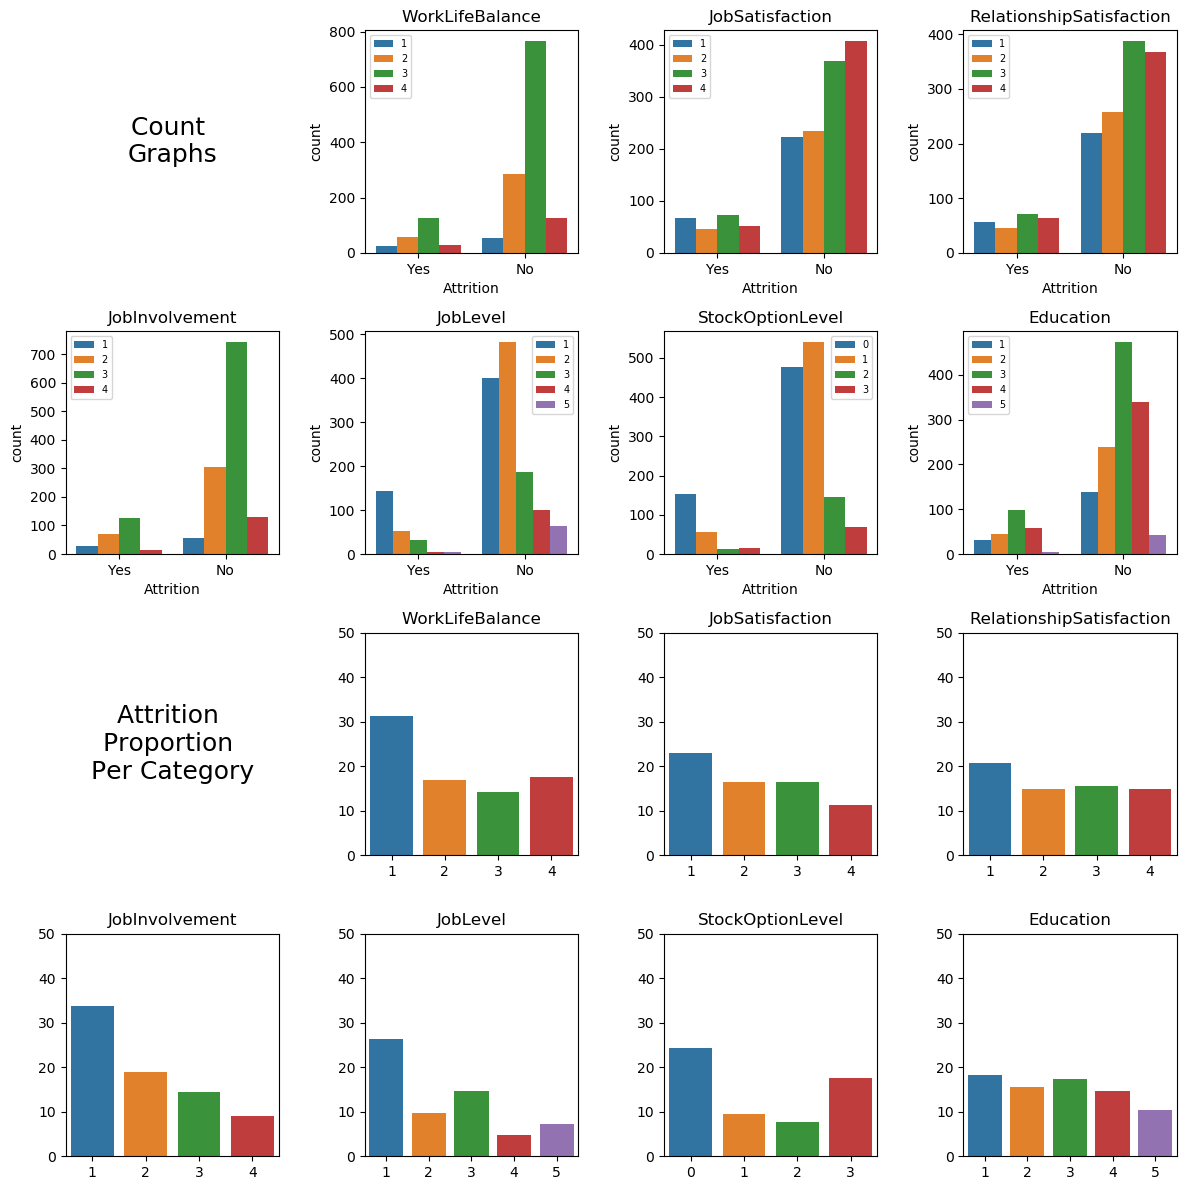

In [56]:
# Variables discrètes - diagrammes en bar

def prop_yes_category(c):
    result = pd.DataFrame()
    yes = df.groupby([c,'Attrition']).Attrition.count().reset_index(name ='Count').sort_values([c])
    tot = yes.groupby([c]).agg({'Count':np.sum}).reset_index().sort_values([c])
    yes = yes[yes['Attrition'] == 'Yes']
    result = [i/j*100 for i,j in zip(yes['Count'], tot['Count'])]
    return(result) 

def plot_prop(c):
    prop = prop_yes_category(c)
    n = sorted(df[c].unique())
    sns.barplot(x = n, y = prop)
    plt.title(c)
    plt.ylim([0,50])

fig = plt.figure(figsize=(12,12), dpi=100)
grid = gridspec.GridSpec(4,4)

titre(['Count \nGraphs','Attrition \nProportion \nPer Category'], [0,2])
col = ['WorkLifeBalance','JobSatisfaction', 'RelationshipSatisfaction','JobInvolvement', 'JobLevel', 'StockOptionLevel', 'Education']

i = 1
j = 0
for c in col:
    if i in range(1,4):
        plt.subplot(grid[0,i])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
        
        plt.subplot(grid[2,i])
        plot_prop(c)
        i +=1
        
    else:
        plt.subplot(grid[1,j])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
           
        plt.subplot(grid[3,j])
        plot_prop(c)
        j +=1

plt.tight_layout()
plt.show()

# l'équilibre de vie n'a pas l'air d'être déterminant dans le départ
# Par contre la satisfaction du travail et des relations l'est
# la plupart des gens partant sont impliqués dans leur travail

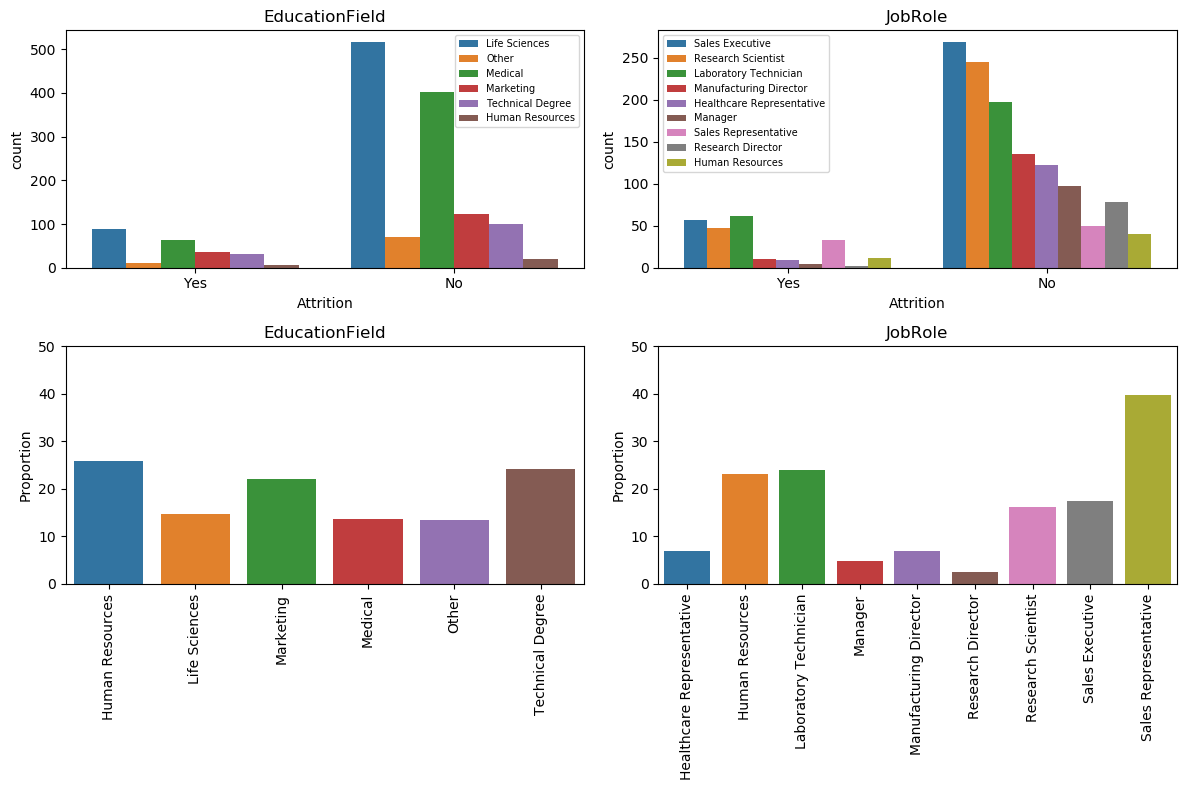

In [58]:
fig = plt.figure(figsize=(12,8), dpi=100)
grid = gridspec.GridSpec(2,2)

col = ['EducationField','JobRole']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.countplot(x= 'Attrition', hue = c, data= df)
    plt.title(c)
    plt.legend(prop={'size':7})
        
    plt.subplot(grid[1,i])
    plot_prop(c)
    plt.xticks(rotation=90)
    plt.ylabel('Proportion')
    i +=1
    
plt.tight_layout()
plt.show()

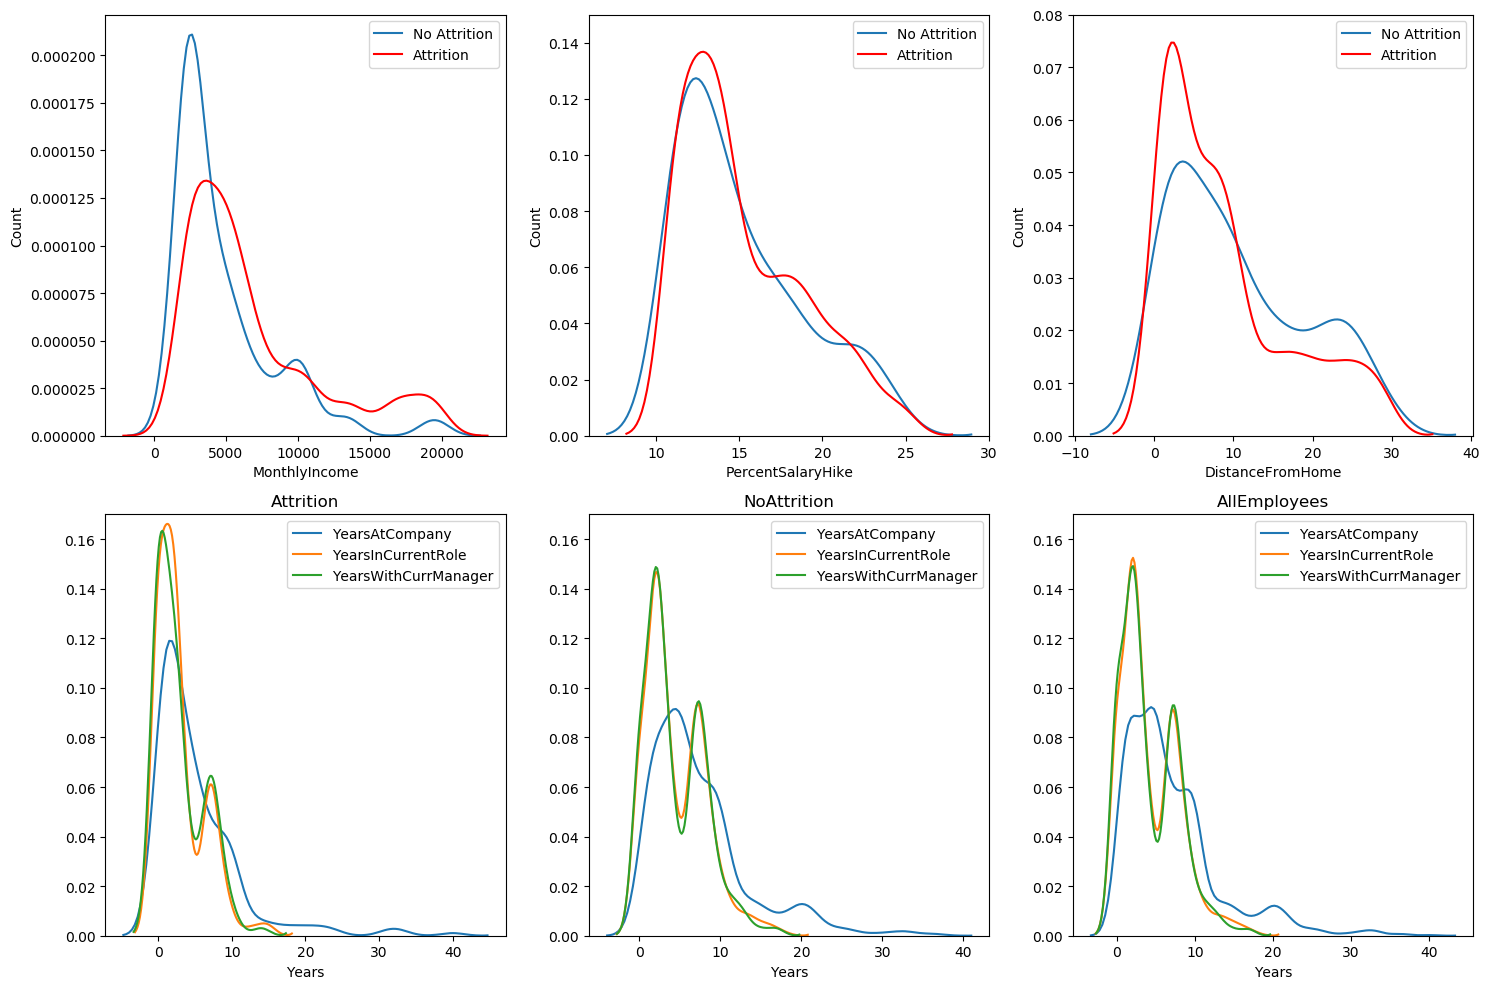

In [78]:
# Variables quantitatives
# MonthlyIncome, PercentSalaryHike, PerformanceRating, DistanceFromHome
# Ancienneté : YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, JobLevel

fig = plt.figure(figsize=(15,10), dpi=100)
grid = gridspec.GridSpec(2,3)

col = ['MonthlyIncome','PercentSalaryHike', 'DistanceFromHome']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.distplot(df0[c], kde = True, hist = False, label = 'No Attrition')
    sns.distplot(df1[c], kde = True, color = 'red', hist = False, label = 'Attrition')
    plt.ylabel('Count')
    if i == 1:
        plt.ylim([0,0.15])
    elif i == 2:
        plt.ylim([0,0.08])
    i +=1

title = ['Attrition','NoAttrition','AllEmployees']
j = 0
for d in dA:
    plt.subplot(grid[1,j])
    sns.distplot(d['YearsAtCompany'], kde = True, hist = False, label = 'YearsAtCompany')
    sns.distplot(d['YearsInCurrentRole'], kde = True, hist = False, label = 'YearsInCurrentRole')
    sns.distplot(d['YearsWithCurrManager'], kde = True, hist = False, label = 'YearsWithCurrManager')
    plt.legend(prop={'size':10}, loc=1)
    plt.ylim([0,0.17])
    plt.xlabel('Years')
    plt.title(title[j])
    j +=1

plt.tight_layout()
plt.show()

In [79]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

# Regression logistique

Nous avons dû choisir un traitement pour nos variables catégoriques. Nous avons choisi de garder en variables continues les variables qui ont plus de quatre catégories et dont la moyenne fait sens (ex: les individus ont du noter leur JobSatisfaction sur une échelle allant de 1 à 4, 4 étant la meilleure note. Faire une moyenne sur cette variable fait bet et bien sens).

Il nous reste donc 7 variables catégoriques qu'il faut donc transformer toutes les variables catégoriques en colonnes indicatrices de catégories. 
Les variables sont : 
- EducationField
- JobRole
- BusinessTravel
- Gender   
- OverTime
- MaritalStatus 
- Department 

## Créons la base de donnée pour la régression logitique

In [80]:
var_cat = ['EducationField', 'JobRole', 'BusinessTravel','MaritalStatus', 'Department' ]
var_bin = ['Gender','OverTime','Attrition']
df1 = pd.DataFrame(index= range(df.shape[0]))
for var in var_cat:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var)
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
for var in var_bin:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var, drop_first= True )
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
df1.head()

,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,...,BusinessTravel_Rarely,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_HR,Department_R&D,Department_Sales,Gender_Male,OverTime_Yes,Attrition_Yes
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,1,0,1,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,0


In [81]:
dfc = df.merge(df1, left_index= True, right_index=True )
dfc = dfc.drop([var for var in var_cat], 1)
dfc = dfc.drop([var for var in var_bin], 1)
dfc = dfc.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18'], 1) 
dfc.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'Busi

# Backwards regression

Nous allons procéder à une backwards logistic regression, c'est à dire que nous allons mettre toutes les variables dans notre modèle, puis éliminer grâce aux p-values, les variables qui ne sont pas significatives pour la prédiction de l'attrition.

In [82]:
X = dfc.drop('Attrition_Yes', 1)

In [83]:
Y = dfc['Attrition_Yes']

In [84]:
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

         Current function value: inf
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1425
Method:                           MLE   Df Model:                           44
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                    -inf
Time:                        10:28:40   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                   -5.1895e+05
                                        LLR p-value:                     1.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0309      0.014     -2.281      0.023      -0.057      -0.004
D

C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarnin

In [86]:
X = dfc.drop('Attrition_Yes', 1) # covariates
y = dfc['Attrition_Yes'] # output - binomial

In [87]:
# Regression Logistique sur l'ensemble de la base de donnée

logreg = LogisticRegression(random_state = 0) #  If int, random_state is the seed used by the random number generator
res_log = logreg.fit(X,y)

# Coefficients

n = len(res_log.coef_[0])
coef = pd.DataFrame(res_log.coef_[0].reshape(n,1), columns = ['Coefficients'])
var = pd.DataFrame(np.array(X.columns).reshape(n,1), columns = ['Variables'])
CoefLog = pd.merge(var,coef, left_index= True, right_index = True)
CoefLog = CoefLog.append({'Variables':'Intercept','Coefficients': res_log.intercept_[0]}, ignore_index = True)
print(CoefLog)

                            Variables  Coefficients
0                                 Age     -0.021622
1                           DailyRate     -0.000229
2                    DistanceFromHome      0.044869
3                           Education      0.017939
4             EnvironmentSatisfaction     -0.368220
5                          HourlyRate      0.003379
6                      JobInvolvement     -0.442735
7                            JobLevel     -0.079189
8                     JobSatisfaction     -0.349870
9                       MonthlyIncome     -0.000041
10                        MonthlyRate      0.000011
11                 NumCompaniesWorked      0.195077
12                  PercentSalaryHike     -0.053263
13                  PerformanceRating      0.765431
14           RelationshipSatisfaction     -0.216976
15                   StockOptionLevel     -0.175584
16                  TotalWorkingYears     -0.064021
17              TrainingTimesLastYear     -0.160613
18          

In [88]:
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(X, Y )
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False  True False  True False False False
 False False False False False False False False False False False  True
 False  True False False  True  True  True  True  True  True  True False
 False  True  True  True False False False  True False False False  True
  True]
[27 30 24 28  1 29  1 23  1 31 32 18 25 19  7  6 20 10  3 21 12 13 14  1 17
  1 16 15  1  1  1  1  1  1  1 26  9  1  1  1  5 22  2  1 11  8  4  1  1]


# Modèles Prédictifs

## Régression Logistique

In [104]:
# Séparation en un training_set et un test_set

train, test = train_test_split(dfc, train_size=0.8, test_size = 0.2)
X_train = train.drop('Attrition_Yes', 1)
y_train = train['Attrition_Yes']
X_test = test.drop('Attrition_Yes', 1)
y_test = test['Attrition_Yes']

print(X_train.shape)
print(X_test.shape)

(1176, 49)
(294, 49)


In [105]:
# Régression sur la base X_train, y_train

res_log = logreg.fit(X_train, y_train)

# Prediction sur le training set

y_predlog = res_log.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predlog)
y_score = res_log.score(X_test,y_test)

print(conf_matrix)
print(y_score) 

[[235   2]
 [ 39  18]]
0.860544217687


## Support Vector Machine

In [109]:
# Linear Support Vector Machine

svm = LinearSVC()
res_svm = svm.fit(X_train,y_train)

# Prediction

y_predsvm = res_svm.predict(X_test)
conf_mat_svm = confusion_matrix(y_test, y_predsvm)
y_score_svm = res_svm.score(X_test,y_test)

print(conf_mat_svm)
print(y_score_svm)  ## ATTENTION n'a pas l'air corrélé à AUC ??? 

[[237   0]
 [ 57   0]]
0.80612244898


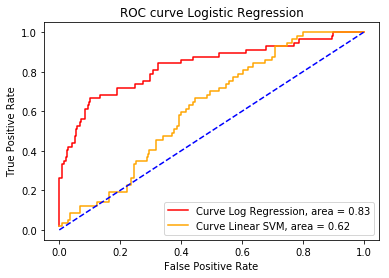

In [110]:
# ROC CURVE

fpr_log, tpr_log,t = roc_curve(y_test,res_log.decision_function(X_test))
log_auc= auc(fpr_log,tpr_log)

fpr_svm, tpr_svm, t = roc_curve(y_test,res_svm.decision_function(X_test))
svm_auc = auc(fpr_svm,tpr_svm)

plt.figure()
plt.plot(fpr_log, tpr_log, color = 'red', label = 'Curve Log Regression, area = %0.2f' %log_auc)
plt.plot(fpr_svm, tpr_svm, color = 'orange', label = 'Curve Linear SVM, area = %0.2f' %svm_auc)
plt.plot([0,1],[0,1], color = 'blue', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Logistic Regression')
plt.legend(loc = 'lower right')
plt.show()

In [103]:
model = (LinearSVC(),LogisticRegression())
res = (clf.fit(X_train,y_train) for clf in model)

def multi_roc_curve(models):
    plt.figure()
    i = 0
    for m in models:
        clf = m
        res = clf.fit(X_train,y_train)
        fpr, tpr, t = roc_curve(y_test,res.decision_function(X_test))
        auc_v = auc(fpr,tpr)
        plt.plot(fpr,tpr,color = sns.color_palette()[0:i], label = '%0.2f, area =%0.2f'%(m,auc_v))
    plt.plot([0,1],[0,1], color = 'blue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = 'lower right')
    plt.show()


multi_roc_curve(model)


TypeError: must be real number, not LinearSVC